In [1]:
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from collections import defaultdict

torch.manual_seed(8770)

In [2]:
device = torch.device('cuda')

# Cats vs. Dogs Dataset
https://www.kaggle.com/c/dogs-vs-cats/overview

In [3]:
data_dir = os.path.join('data', 'cats_vs_dogs')
class_names = ('cat', 'dog')

In [4]:
config = {
    'batch_size': 128,
    'learning_rate': 1e-3,
}

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
#     transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_path = os.path.join(data_dir, 'train')
train_dataset = datasets.ImageFolder(train_path, transform=transform)
train_data_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

validation_path = os.path.join(data_dir, 'validation')
validation_dataset = datasets.ImageFolder(validation_path, transform=transform)
validation_data_loader = DataLoader(validation_dataset, batch_size=config['batch_size'], shuffle=True)

test_path = os.path.join(data_dir, 'test')
test_dataset = datasets.ImageFolder(test_path, transform=transform)
test_data_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True)

train_dataset, validation_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 16000
     Root location: data\cats_vs_dogs\train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 4000
     Root location: data\cats_vs_dogs\validation
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 5000
     Root location: data\cats_vs_dogs\test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.22

# Baseline Model

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(32 * 120 * 120, 100)
        self.fc2 = nn.Linear(100, num_classes)
        
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20 * 29 * 29, 50)
        self.fc2 = nn.Linear(50, 2)
    
    def forward(self, x):
        y = self.conv1(x)
        y = F.relu(y)
        y = F.max_pool2d(y, 2)
        y = self.conv2(y)
        y = F.relu(y)
        y = F.max_pool2d(y, 2)
        y = torch.flatten(y, 1)
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = F.log_softmax(y, dim=1)
        return y

In [8]:
def train(model, data_loader):
    global optimizer, scheduler
    train_losses = []
    model.train()
    for step, (X, Y) in (pbar := tqdm(enumerate(data_loader, 1))):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.cpu().detach().numpy())
        pbar.set_description(f"[{step}/{len(data_loader)}] loss={loss:.4f}")
    return train_losses

In [9]:
def evaluate(model, data_loader, C=2):
    confusion_matrix = torch.zeros(C, C)
    val_losses = torch.zeros(len(data_loader))
    model.eval()
    with torch.no_grad():
        for step, (X, Y) in (pbar := tqdm(enumerate(data_loader, 1))):
            X, Y = X.to(device), Y.to(device)
            outputs = model(X)
            for o, actual_class in zip(outputs, Y):
                pred_class = torch.argmax(o)
                confusion_matrix[actual_class, pred_class] += 1
            val_loss = criterion(outputs, Y)
            val_losses[step-1] = val_loss
            pbar.set_description(f"[{step}/{len(data_loader)}] val_loss={val_loss:.4f}")
        return torch.mean(val_losses), confusion_matrix

In [10]:
def plot_learning_curve(history):
    def moving_average(x, N):
        y = np.convolve(x, np.ones(N)/N, mode='same')
        y[:2] = np.nan
        y[-2:] = np.nan
        return y

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.plot(history['train']['batch'], color="orange", alpha=0.5, label="train")
    ax.plot(moving_average(history['train']['batch'], 5), color="darkorange", label="smoothed train")

    val_x = torch.arange(1, len(history['val']['epoch']) + 1, 1)
    val_x *= len(train_data_loader)
    ax.scatter(val_x, history['val']['epoch'], color="green", marker="o", label="validation")

    for x in val_x:
        ax.axvline(x=x, ymin=0, ymax=1, linestyle="--", color="gray", alpha=0.4)

    ax.set_xlim(0, val_x[-1] + 1)
    ax.set_ylim(0, 1.0)
    ax.set_xticks(val_x)
    ax.set_xlabel(f"Batch (size={config['batch_size']})")
    ax.set_ylabel("CE loss")
    # ax.set_title("CNN")
    ax.legend()
    plt.show()

In [11]:
cnn = CNN(num_classes=2).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=config['learning_rate'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3 * len(train_data_loader), gamma=0.05)

In [14]:
history = defaultdict(dict)
history["train"]["batch"] = []
history["val"]["epoch"] = []

0it [00:00, ?it/s]

Epoch 1


[125/125] loss=0.6451: : 125it [00:49,  2.54it/s]
[32/32] val_loss=0.6274: : 32it [00:12,  2.53it/s]


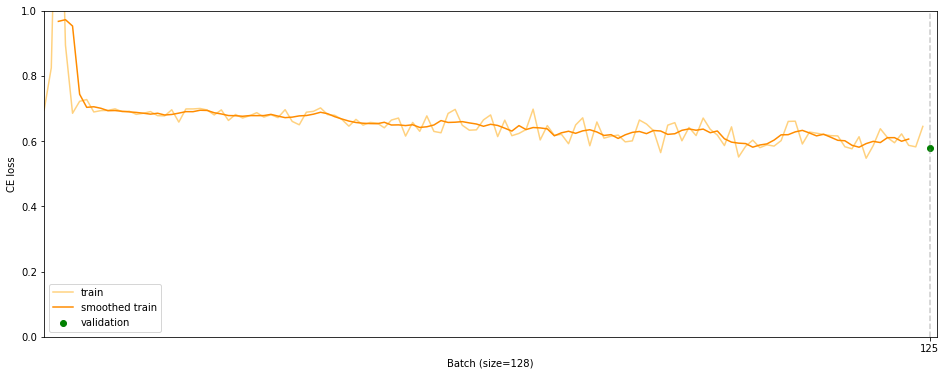

0it [00:00, ?it/s]

Epoch 2


[125/125] loss=0.4663: : 125it [00:49,  2.52it/s]
[32/32] val_loss=0.5145: : 32it [00:12,  2.54it/s]


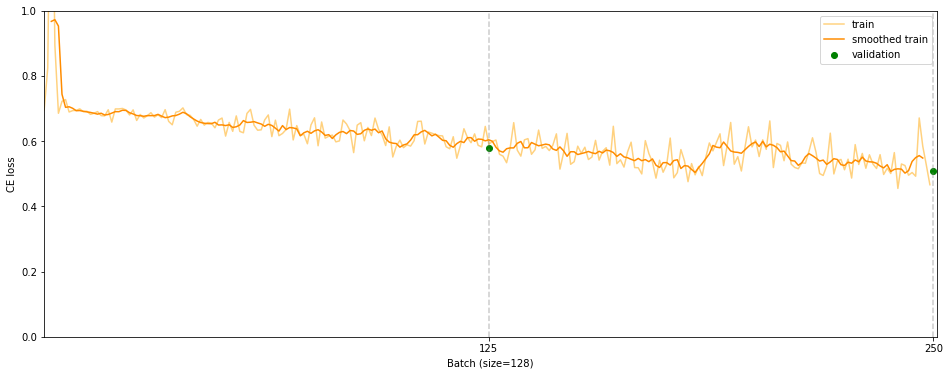

0it [00:00, ?it/s]

Epoch 3


[125/125] loss=0.4110: : 125it [00:49,  2.53it/s]
[32/32] val_loss=0.4283: : 32it [00:12,  2.58it/s]


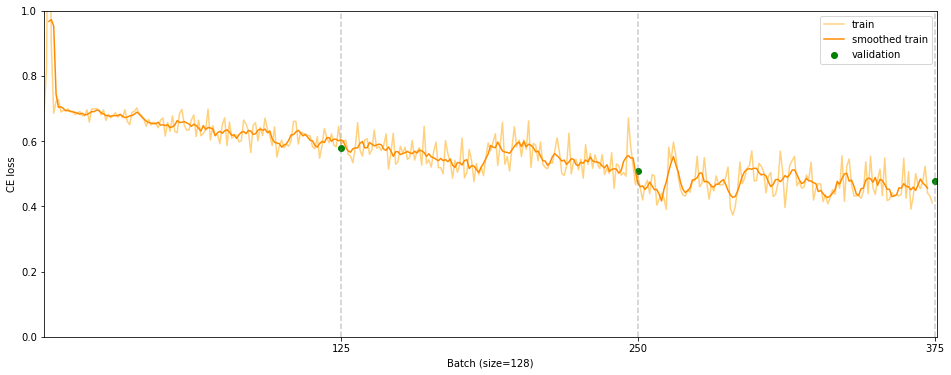

0it [00:00, ?it/s]

Epoch 4


[125/125] loss=0.5462: : 125it [00:48,  2.60it/s]
[32/32] val_loss=0.4270: : 32it [00:12,  2.58it/s]


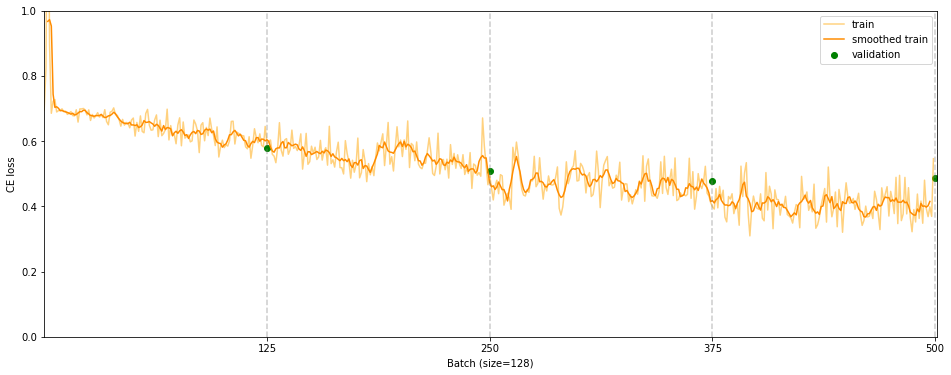

0it [00:00, ?it/s]

Epoch 5


[125/125] loss=0.3396: : 125it [00:49,  2.51it/s]
[32/32] val_loss=0.4074: : 32it [00:12,  2.48it/s]


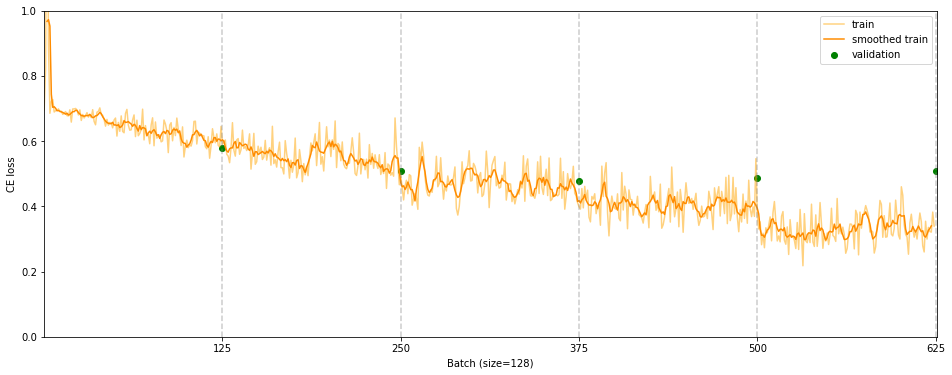

0it [00:00, ?it/s]

Epoch 6


[125/125] loss=0.2461: : 125it [00:48,  2.56it/s]
[32/32] val_loss=0.4991: : 32it [00:12,  2.57it/s]


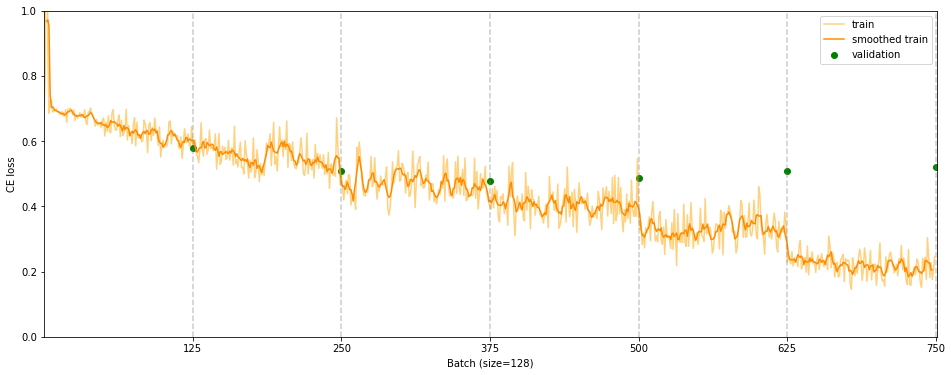

0it [00:00, ?it/s]

Epoch 7


[125/125] loss=0.2449: : 125it [02:31,  1.21s/it]
[32/32] val_loss=0.6088: : 32it [00:30,  1.04it/s]


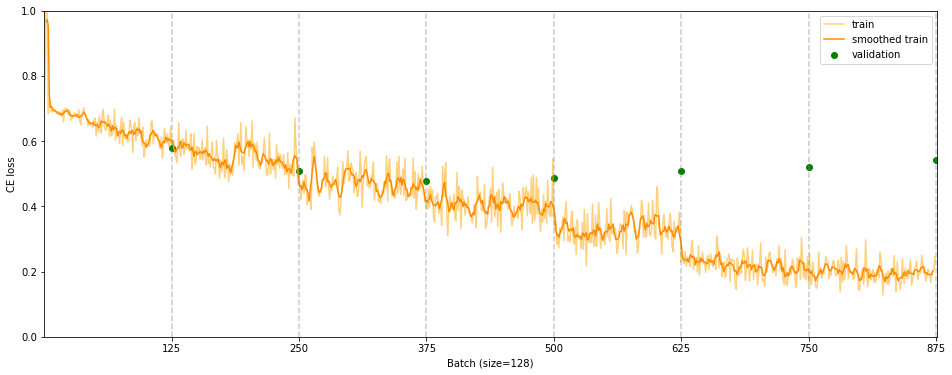

0it [00:00, ?it/s]

Epoch 8


[125/125] loss=0.1287: : 125it [00:57,  2.17it/s]
[32/32] val_loss=0.7413: : 32it [00:13,  2.33it/s]


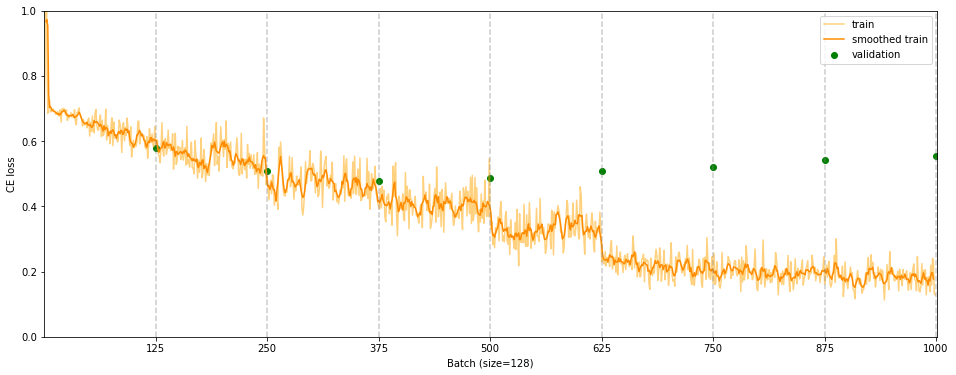

0it [00:00, ?it/s]

Epoch 9


[125/125] loss=0.2067: : 125it [00:51,  2.45it/s]
[32/32] val_loss=0.6052: : 32it [00:13,  2.33it/s]


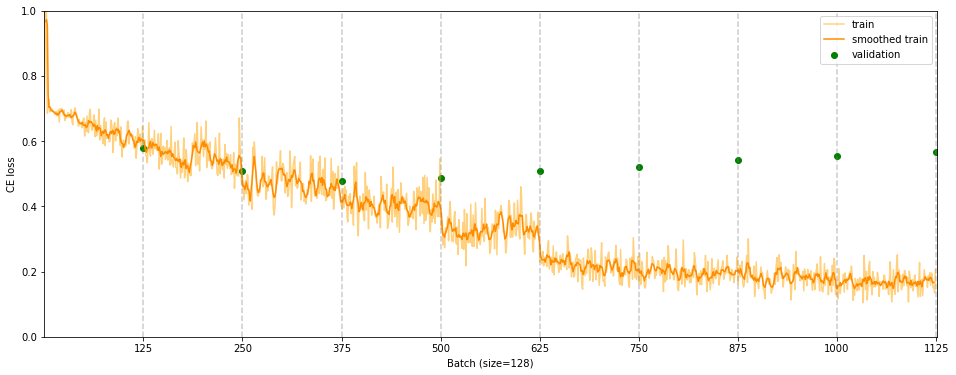

0it [00:00, ?it/s]

Epoch 10


[125/125] loss=0.1168: : 125it [00:49,  2.51it/s]
[32/32] val_loss=0.4870: : 32it [00:13,  2.39it/s]


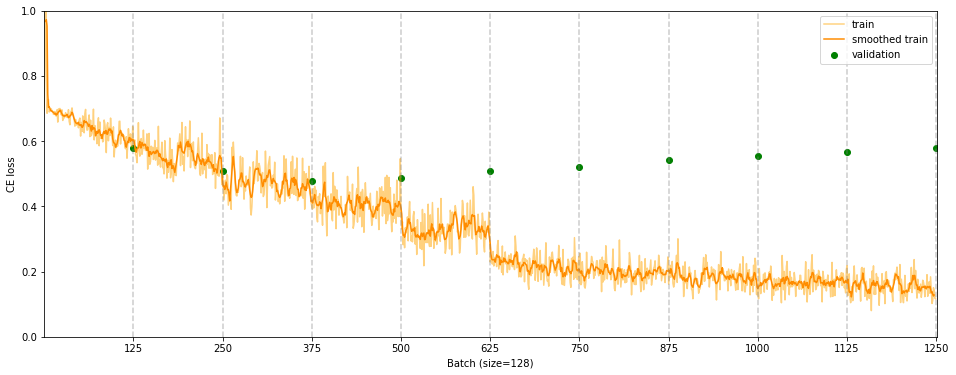

In [15]:
for epoch in range(1, 10 + 1):
    print(f"Epoch {epoch}")
    
    train_losses = train(cnn, train_data_loader)
    history['train']['batch'].extend(train_losses)
    
    val_loss, cm = evaluate(cnn, validation_data_loader, C=cnn.num_classes)
    history['val']['epoch'].append(val_loss)
    
    plot_learning_curve(history)

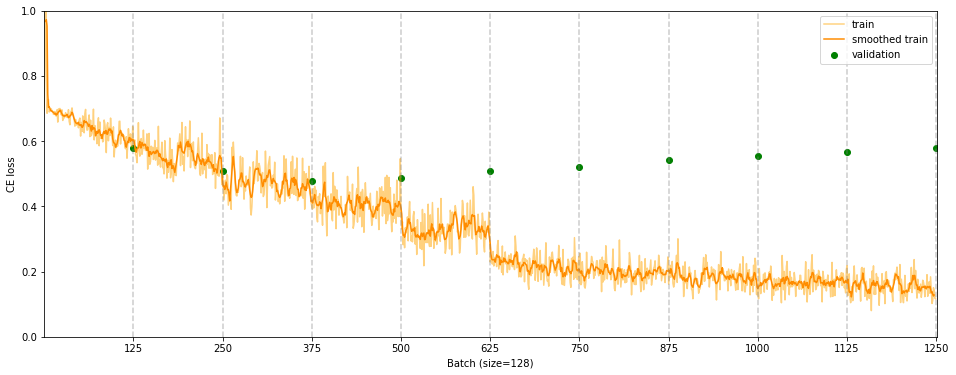

In [16]:
plot_learning_curve(history)

In [17]:
test_loss , test_cm = evaluate(cnn, test_data_loader, C=cnn.num_classes)

[40/40] val_loss=1.8029: : 40it [01:21,  2.03s/it]


In [18]:
"test accuracy", test_cm.trace() / test_cm.sum()

('test accuracy', tensor(0.7700))

In [19]:
test_cm

tensor([[1939.,  561.],
        [ 589., 1911.]])

# Bayesian Neural Network

# 

We can predict the final output from a BNN as follows:

$$
p(y^* | \mathcal{D})
= \mathbb{E}_{p(\theta | \mathbb{D})} \{ p(y^* | \theta) \}
= \frac{1}{K} \sum_{k=1}^{K} p(y^* | \theta_k)
$$

Basically, it just an average over $K$ predictions that their parameters are drawn from $p(\theta | \mathcal{D})$.

In [2]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [ ]:
class BCNN(nn.Module):
    def __init__(self, CNN, num_classes=2):
        super(BCNN, self).__init__()
        
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(32 * 120 * 120, 100)
        self.fc2 = nn.Linear(100, num_classes)
        
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20 * 29 * 29, 50)
        self.fc2 = nn.Linear(50, 2)
    
    def forward(self, x):
        y = self.conv1(x)
        y = F.relu(y)
        y = F.max_pool2d(y, 2)
        y = self.conv2(y)
        y = F.relu(y)
        y = F.max_pool2d(y, 2)
        y = torch.flatten(y, 1)
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = F.log_softmax(y, dim=1)
        return y